In [ ]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import random # Added by Caleb
import math # Added by Caleb
import os
import torch
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/') ## mount to drive. This will ask for permission to access your Google drive each time

Mounted at /content/drive/


In [ ]:
# Need for loading data, will figure out how to pull from the other file later
class CustomImageDataset(Dataset):
    def __init__(self, x_data, y_data, img_dir=None, transform=None, target_transform=None):
        self.img_labels = y_data
        self.img_dir = img_dir
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.x_data[idx]
        label = self.y_data[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



In [ ]:
##### Code for loading data, duplicate in Data Augmentation Notebook #############


def saveNumpyAsCSV(data, data_folder, filename):
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data" #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".csv") #joing path and adding .npy to filename passed in 
  np.savetxt(data_file_path, data, delimiter=',') #saves file to specific data path 

def saveNumpyData(data, data_folder, filename):
  '''Saves a numpy array to file'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data" #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".npy") #joing path and adding .npy to filename passed in 
  np.save(data_file_path, data) #saves file to specific data path 

def loadNumpyData(data_folder, filename):
  '''Saves a numpy array to file'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data" #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".npy") #joing path and adding .npy to filename passed in
  return np.load(data_file_path) #loads file from a specific data path 


def loadDataSet(data_folder, filename):
  '''Loads an object from file, in this case a dataset'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data" #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".pt")  #joing path and adding .npy to filename passed in 
  print(data_file_path)
  return torch.load(data_file_path) #returns dataset from filepath/filename 

def loadMulDataSets(data_folder, filename_list):
  '''Place names of files in a list for loading mulitple files easily
    filename_list should be the filenames you want to load the dataset from
    data_folder is the folder inside "Data" you want to load data from
    '''
  list_of_datasets = [] #empty list to start appending datasets we pull out of files
  for filename in filename_list: #loop through each filename 
    list_of_datasets.append(loadDataSet(data_folder, filename))
  return list_of_datasets

In [ ]:
# Loading data from file 
DATA_FOLDER = "1"
DATA_FILE_NAMES = ["train_data", "valid_train", "test_data"]
train_data, valid_data, test_data = loadMulDataSets(DATA_FOLDER, DATA_FILE_NAMES)
x_train_len = len(train_data)
x_val_len = len(valid_data)
print(x_train_len)
print(x_train_len)

/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data/1/train_data.pt
/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data/1/valid_train.pt
/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data/1/test_data.pt
2400
2400


In [ ]:
# Placing in data loader 
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
# Custom CNN
# Defining the CNN architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5, padding=2, padding_mode='zeros', dtype=float)
   ## nn.MaxPool2d()
    self.conv2 = nn.Conv2d(6, 16, 5, dtype=float)
    self.fc1 = nn.Linear(16 * 56 * 2, 800, dtype=float)
    self.fc2 = nn.Linear(800, 200, dtype=float) 
    self.fc3 = nn.Linear(200, 50, dtype=float)
    self.fc4 = nn.Linear(50, 4, dtype=float)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(-1, 16 * 56 * 2) # At this point the feature map is 5 x 5 x 16
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
# Setting up model
# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
flag_cuda = torch.cuda.is_available()
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=.001)


print(type(model))


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1792, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=4, bias=True)
)
<class '__main__.Net'>


In [ ]:
def saveModel(model, filename):
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Code/Models" #path to data folder in drive
  model_file_path = os.path.join(competition_path, filename+".pt")  #joing path and adding .npy to filename passed in
  torch.save(model.state_dict(), model_file_path)

def loadModelStateFromFile(model, filename):
  ''' Load model's state onto model passed in from a model file'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Code/Models/" #path to data folder in drive
  model_file_path = os.path.join(competition_path, filename+".pt")  #joing path and adding .npy to filename passed in
  print(model_file_path)
  model.load_state_dict(torch.load(model_file_path)) # Should not need a return since the model will be modified through its object 

def loadModelStateDict(filename):
  '''Loads model state dict from filename specifed'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Code/Models/" #path to data folder in drive
  model_file_path = os.path.join(competition_path, filename+".pt")  #joing path and adding .npy to filename passed in
  return torch.load(model_file_path)


Epoch: 1 	Training Loss: 0.769658 	Validation Loss: 0.645759
Validation loss decreased (inf --> 0.645759).  Saving model ...
Epoch: 2 	Training Loss: 0.621231 	Validation Loss: 0.616396
Validation loss decreased (0.645759 --> 0.616396).  Saving model ...
Epoch: 3 	Training Loss: 0.517972 	Validation Loss: 0.611468
Validation loss decreased (0.616396 --> 0.611468).  Saving model ...
Epoch: 4 	Training Loss: 0.403222 	Validation Loss: 0.608703
Validation loss decreased (0.611468 --> 0.608703).  Saving model ...
Epoch: 5 	Training Loss: 0.275749 	Validation Loss: 0.736406
Epoch: 6 	Training Loss: 0.199126 	Validation Loss: 1.082185
Epoch: 7 	Training Loss: 0.149773 	Validation Loss: 0.967540


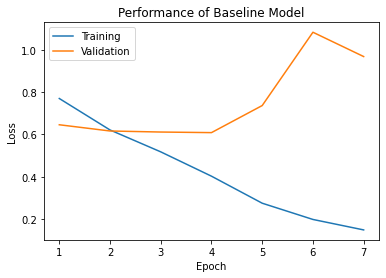

In [ ]:
from sklearn.metrics import f1_score 
# Specifying the number of epochs
n_epochs = 7
model_name = "Test_Model_1"

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):
  # Unpacking the number of epochs to train the model
  epochs_list = [*range(1,n_epochs+1)]

  # List to store loss to visualize
  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss

  for epoch in epochs_list:
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      
      ######################
      # Training the model #
      ######################
      model.train()
      for data, target in train_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          # Clearing the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: Computing predicted outputs
          output = model(data)
          # Calculating the batch loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          
      ########################    
      # Validating the model #
      ########################
      model.eval()
      for data, target in valid_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      # Calculating average losses
      train_loss = train_loss/x_train_len
      valid_loss = valid_loss/x_val_len
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      # Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          saveModel(model, model_name)
          #torch.save(model.state_dict(), 'model_cifar.pt')
          valid_loss_min = valid_loss
        
  return epochs_list, train_losslist, valid_losslist

# Executing the training
epochs_list, train_losslist, valid_losslist = trainNet(
    model,criterion,optimizer,n_epochs,flag_cuda)

# Plotting the learning curves
plt.plot(epochs_list, train_losslist, epochs_list, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Baseline Model")
plt.show()

In [ ]:

classes = [0, 1, 2, 3]

def assessNet(model,criterion):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data
  for data, target in test_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

      # Converting output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # Comparing predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      # Calculating test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
  return 

# Executing the assessment
assessNet(model,criterion)

Test Loss: 1.167866

Test Accuracy of          0: 94% (551/584)
Test Accuracy of          1: 23% (10/43)
Test Accuracy of          2: 72% (27/37)
Test Accuracy of          3: 23% (32/136)

Test Accuracy (Overall): 77% (620/800)
